# Hands-on: Classification of Liver With or Without Tumor on CT Images
## 01 Data Visualization
Dataset reference: [Medical Segmentation Decathlon](http://medicaldecathlon.com/)

## 1\. Prepare the Enviornment

In [ ]:
# import some Python packages
# 所有放在「 # 」之後的任何內容都會被當成注釋
import os
import numpy as np
import nibabel as nib
from google.colab import drive
from matplotlib import pyplot as plt

## 2\. Download the Dataset

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive')

In [ ]:
# unzip the file
#如果我的雲端硬碟裡沒有liver_classification這個資料夾（代表沒有解壓縮過），且擁有liver_classification.zip，那我就執行解壓縮
if not os.path.exists(r"./liver_classification") and os.path.exists(r"./liver_classification.zip"):
    !unzip liver_classification.zip

When you finished downloading the dataset, you can check the data by clicking the **"FILE"** on the left side. \\
![](https://i.imgur.com/KTn370m.png)

## 3\. Data Visualization
Firstly, let's take a look at the example data. We provide a pair of image and label data.


In [ ]:
# Set the folder path of the example data
# 在你想要選取的資料夾旁有三個點點，按下去之後就可以選擇複製路徑，得到下面的資訊唷!
data_dir = './liver_classification/example_file'

In [ ]:
# Load the image and label
image_nifti = nib.load(os.path.join(data_dir, 'image', 'liver_101.nii.gz'))
label_nifti = nib.load(os.path.join(data_dir, 'label', 'liver_101.nii.gz'))

In [ ]:
# [optional] Check the header
print(image_nifti.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 683   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.        0.7050781 0.7050781 0.7       0.        0.        0.
 0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b''
qform_code      : aligned
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -191.14746
qoffset_y       : 5.852539
qoffset

Both image_nifti and label_nifti are "Nifti1Image" objects.\
If we want to get the "image" itself, we would use **`.get_fdata`.**

In [ ]:
# Get the numpy array of the image and label
image = image_nifti.get_fdata()
label = label_nifti.get_fdata()

In [ ]:
# Check the shape of the image and label
print("Shape of the image:", image.shape)
print("Shape of the label:", label.shape)

Shape of the image: (512, 512, 683)
Shape of the label: (512, 512, 683)


Let's see the shapes of the image and label.\
The shape (x, y, z) represents sizes of the three directions. \
Every two directions can form a corressponding plane, which is called axial, coronal, and sagittal.
![](https://www.ipfradiologyrounds.com/_images/reconstruction-planes.png)
https://www.ipfradiologyrounds.com/_images/reconstruction-planes.png

### 3-1. Image
Let's try to visualize the image in axial, coronal, and sagittal planes.

In [ ]:
# function for plotting images
#寫一個函式，選取顯示第幾張照片（axial照片總共有512張，coronal照片總共有512張，sagittal照片總共有683張。）
#我要顯示axial的第z張照片，coronal的第y張照片，sagittal的第x張照片
def plot_image(image, x, y, z):
  image_plot = image[::-1, ::-1, ::-1]      #(?)顯示為黑白圖片

  fig = plt.figure(figsize=(15, 15))        #宣告畫布，15x15

  #把一張畫布，分成1x3小個畫布，放不同圖片
  ax1 = fig.add_subplot(1, 3, 1)                 #(row, column, 第幾張圖)
  ax1.set_title("Axial view with slice number {}".format(z))    #format是將變數放入字串{}的位置
  ax1 = plt.imshow(image_plot[:, :, z].T, cmap='gray')

  ax2 = fig.add_subplot(1, 3, 2)
  ax2.set_title("Coronal view with slice number {}".format(y))
  ax2 = plt.imshow(image_plot[:, y, :].T, cmap='gray')

  ax3 = fig.add_subplot(1, 3, 3)
  ax3.set_title("Sagittal view with slice number {}".format(x))
  ax3 = plt.imshow(image_plot[x, :, :].T, cmap='gray')
  plt.show()

You can set which slice to visualize.\
[Practice] Adjust x, y, and z to see the image of different slices.

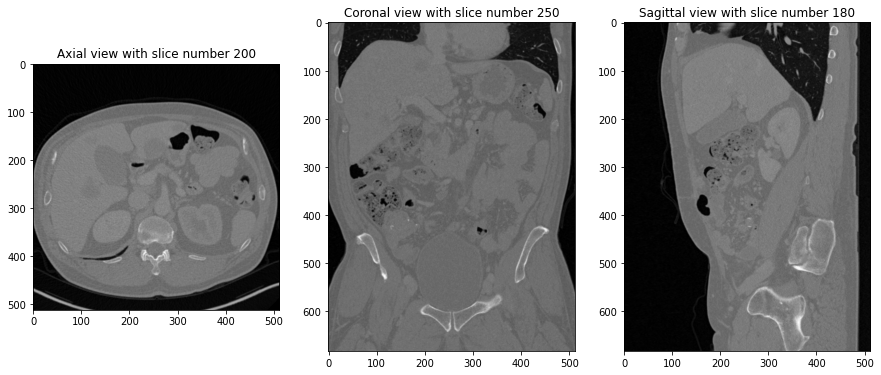

In [ ]:
# Set which slice to visualize
############# change here #############
x = 180
y = 250
z = 200
############# change here #############

plot_image(image, x, y, z)

讓我們嘗試一個簡單的預處理 --**windowing**。\
windowing是CT圖像常用的調整方法。.\
它可以改變亮度和對比度，讓醫生更好地查看檢查區域。\
亨氏單位為其所測量之介質的線性衰減係數的線性映射，其定義將蒸餾水與空氣在標準溫度與標準壓力下的阻射率分別設為0 HU和-1,000 HU。

![](https://www.stepwards.com/wp-content/uploads/2016/08/Screen-Shot-2017-02-28-at-9.42.03-PM-e1488336428473.png)


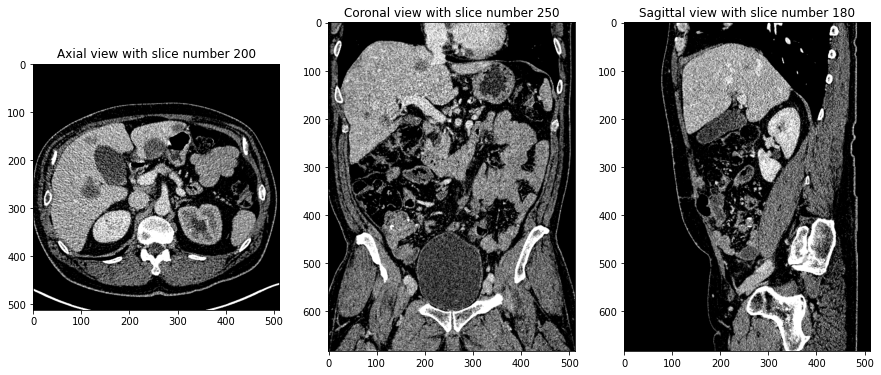

In [ ]:
# [實踐看看] 調整圖像的window
# 如果設置np.clip(image, -50, 200)，就表示把小於-50的值全部改成-50，大於200的值全部改成200。

#調整對比
############# change here #############
image_windowing = np.clip(image, -50, 200)
############# change here #############

plot_image(image_windowing, x, y, z)

### 3-2. Label
在label數據中，它顯示了肝臟和腫瘤的位置

In [ ]:
# Check the components in label data
#三分類
print(np.unique(label))

[0. 1. 2.]


在這種情況下，0 表示背景，1 表示肝臟，2 表示肝臟腫瘤。

In [ ]:
# function of plotting both images and labels
#顯示出2列3行的圖片（總共六張），分別為原始axial照片，原始coronal照片，原始sagittal照片，和與其對應的label圖
def plot_both(image, label, x, y, z):
  image_plot = image[::-1, ::-1, ::-1]
  label_plot = label[::-1, ::-1, ::-1]
  fig = plt.figure(figsize=(15, 15))

  ax1 = fig.add_subplot(2, 3, 1)
  ax1.set_title("Axial view with slice number {}".format(z))
  ax1 = plt.imshow(image_plot[:, :, z].T, cmap='gray')

  ax1_label = fig.add_subplot(2, 3, 4)
  ax1_label = plt.imshow(label_plot[:, :, z].T)

  ax2 = fig.add_subplot(2, 3, 2)
  ax2.set_title("Coronal view with slice number {}".format(y))
  ax2 = plt.imshow(image_plot[:, y, :].T, cmap='gray')

  ax2_label = fig.add_subplot(2, 3, 5)
  ax2_label = plt.imshow(label_plot[:, y, :].T)

  ax3 = fig.add_subplot(2, 3, 3)
  ax3.set_title("Sagittal view with slice number {}".format(x))
  ax3 = plt.imshow(image_plot[x, :, :].T, cmap='gray') 
  
  ax3_label = fig.add_subplot(2, 3, 6)
  ax3_label = plt.imshow(label_plot[x, :, :].T)
  plt.show()

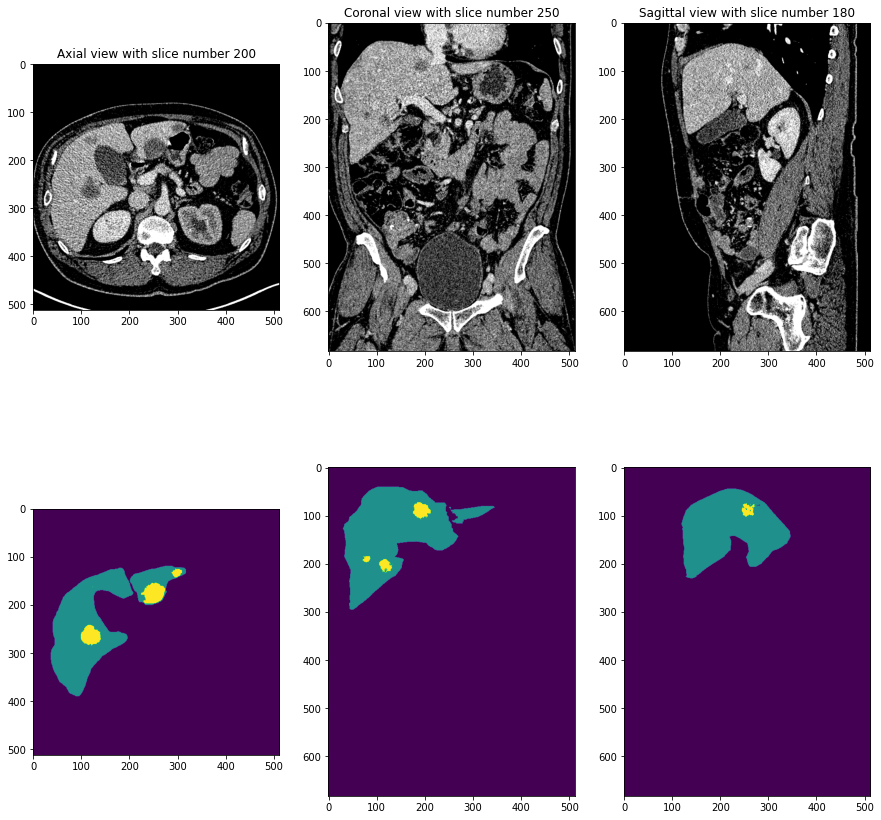

In [ ]:
# Set which slice to visualize
#label紫色是背景(0) 綠色是肝臟(1) 黃色是腫瘤(2)
############# change here #############
x = 180
y = 250
z = 200
############# change here #############

plot_both(image_windowing, label, x, y, z)

為了避免學習不重要甚至嘈雜的信息，我們經常通過將背景區域設置為 0 來執行**"masking"**。\
0:黑色-255:白色
![](https://help.apple.com/assets/5D6EB1CB094622CB34375CC7/5D6EB1D4094622CB34375CDC/en_US/bfc313b52ddd704c03eac92d5e60e76a.png)

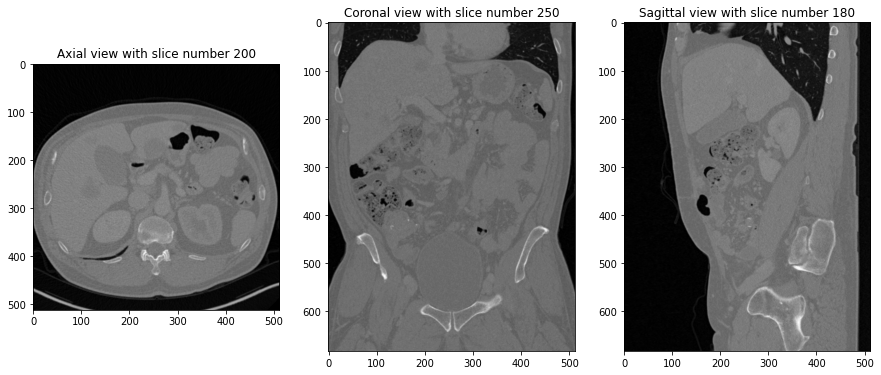

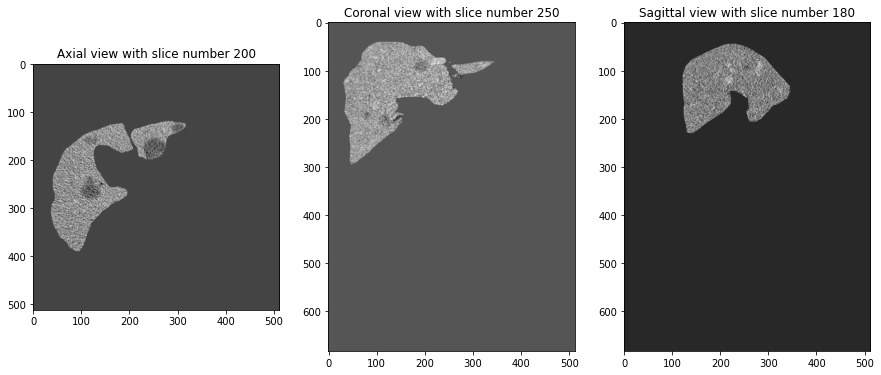

In [ ]:
# 執行masking
image_masking = image.copy()
image_masking[np.where(label == 0)] = 0
plot_image(image, x, y, z)
plot_image(image_masking, x, y, z)